# 1-1、结构化数据建模流程范例

## 一、准备数据
titanic数据集的目标是根据乘客们信息预测他们在Titanic号撞击冰山沉没侯能否生存。
结构化数据一般会使用Pandas中的DataFrame进行预处理

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models,layers

In [5]:
dftrain_raw = pd.read_csv('./data/titanic/train.csv')
dftest_raw = pd.read_csv('./data/titanic/test.csv')
dftrain_raw.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,493,0,1,"Molson, Mr. Harry Markland",male,55.0,0,0,113787,30.5000,C30,S
1,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C
2,388,1,2,"Buss, Miss. Kate",female,36.0,0,0,27849,13.0000,NaN,S
3,192,0,2,"Carbines, Mr. William",male,19.0,0,0,28424,13.0000,NaN,S
4,687,0,3,"Panula, Mr. Jaako Arnold",male,14.0,4,1,3101295,39.6875,NaN,S
5,16,1,2,"Hewlett, Mrs. (Mary D Kingcome)",female,55.0,0,0,248706,16.0000,NaN,S
6,228,0,3,"Lovell, Mr. John Hall (""Henry"")",male,20.5,0,0,A/5 21173,7.2500,NaN,S
7,884,0,2,"Banfield, Mr. Frederick James",male,28.0,0,0,C.A./SOTON 34068,10.5000,NaN,S
8,168,0,3,"Skoog, Mrs. William (Anna Bernhardina Karlsson)",female,45.0,1,4,347088,27.9000,NaN,S
9,752,1,3,"Moor, Master. Meier",male,6.0,0,1,392096,12.4750,E121,S


### 字段说明
- Survived:0代表死亡，1代表存活【y标签】
- Pclass:乘客所持票类，有三种值(1,2,3) 【转换成onehot编码】
- Name:乘客姓名 【舍去】
- Sex:乘客性别 【转换成bool特征】
- Age:乘客年龄(有缺失) 【数值特征，添加“年龄是否缺失”作为辅助特征】
- SibSp:乘客兄弟姐妹/配偶的个数(整数值) 【数值特征】
- Parch:乘客父母/孩子的个数(整数值)【数值特征】
- Ticket:票号(字符串)【舍去】
- Fare:乘客所持票的价格(浮点数，0-500不等) 【数值特征】
- Cabin:乘客所在船舱(有缺失) 【添加“所在船舱是否缺失”作为辅助特征】
- Embarked:乘客登船港口:S、C、Q(有缺失)【转换成onehot编码，四维度 S,C,Q,nan】

利用Pandas的数据可视化功能我们可以简单地进行探索性数据分析EDA(Exploratory Data Analysis)。比如，Labels分布情况如下

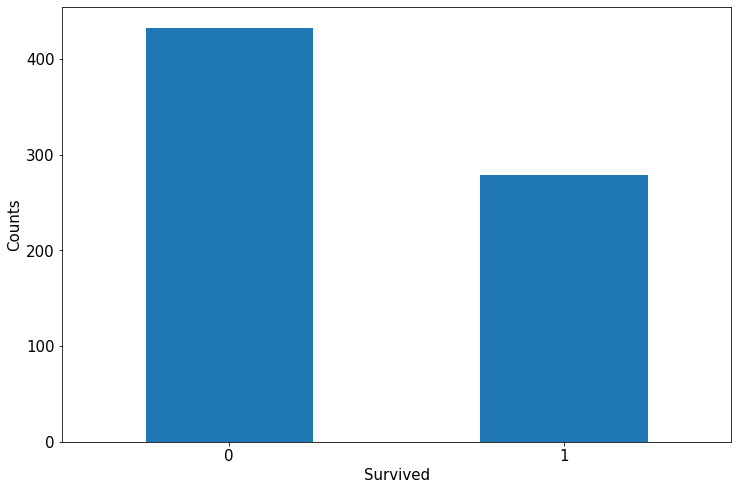

In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
ax = dftrain_raw['Survived'].value_counts().plot(kind='bar',figsize=(12,8),fontsize=15,rot=0)
ax.set_ylabel('Counts',fontsize=15)
ax.set_xlabel('Survived',fontsize=15)
plt.show()

#### 年龄分布情况

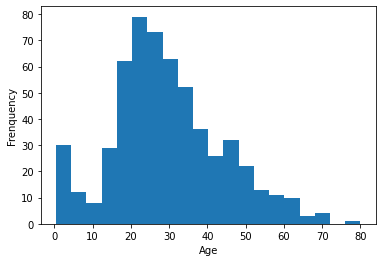

In [27]:
# print(list(dftrain_raw['Age']))
# print(type(list(dftrain_raw['Age'])))
plt.hist(np.array(list(dftrain_raw['Age'])),bins=20)
plt.ylabel('Frenquency',fontsize=10)
plt.xlabel('Age',fontsize=10)
plt.show()

### 年龄和label的相关性

Text(0, 0.5, 'Density')

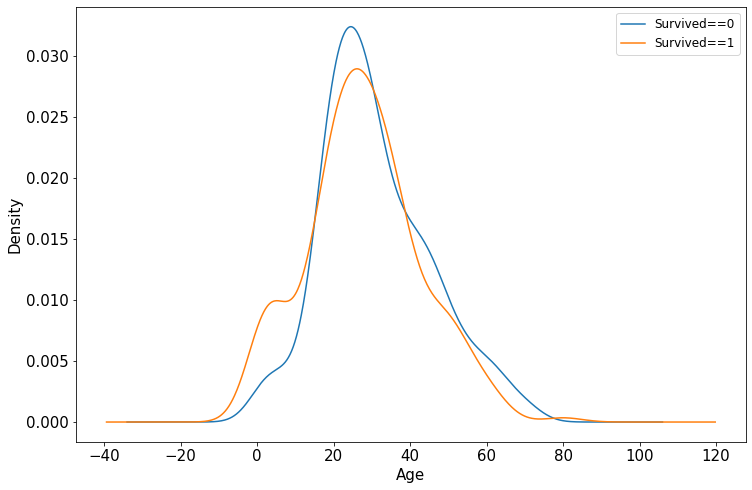

In [29]:
%matplotlib inline
ax = dftrain_raw.query('Survived==0')['Age'].plot(kind='density',figsize=(12,8),fontsize=15)
dftrain_raw.query('Survived==1')['Age'].plot(kind='density',figsize=(12,8),fontsize=15)
ax.legend(['Survived==0','Survived==1'],fontsize=12)
ax.set_xlabel('Age',fontsize=15)
ax.set_ylabel('Density',fontsize=15)

### 下面为正式的数据预处理

In [30]:
def preprocessing(dfdata):
    dfresult = pd.DataFrame()
    
    #Pclass,get_dummies对特征进行one-hot编码
    dfPclass = pd.get_dummies(dfdata['Pclass'])
    dfPclass.columns = ['Pclass_'+str(x) for x in dfPclass.columns]
    dfresult = pd.concat([dfresult,dfPclass],axis=1)
    
    #Sex
    dfSex = pd.get_dummies(dfdata['Sex'])
    dfresult = pd.concat([dfresult,dfSex],axis=1)
    
    #Age
    dfresult['Age'] = dfdata['Age'].fillna(0)
    dfresult['Age_null'] = pd.isna(dfdata['Age']).astype('int32')
    
    #sibsp,parch,fare
    dfresult['SibSp'] = dfdata['SibSp']
    dfresult['Parch'] = dfdata['Parch']
    dfresult['Fare'] = dfdata['Fare']
    
    #Carbin
    dfresult['Cabin_null'] = pd.isna(dfdata['Cabin']).astype('int32')
    dfEmbarked = pd.get_dummies(dfdata['Embarked'],dummy_na=True)
    dfEmbarked.columns = ['Embarked_'+str(x) for x in dfEmbarked.columns]
    dfresult = pd.concat([dfresult,dfEmbarked],axis=1)
    
    return(dfresult)

In [32]:
x_train = preprocessing(dftrain_raw)
y_train = dftrain_raw['Survived'].values

x_test = preprocessing(dftest_raw)
y_test = dftest_raw['Survived'].values

print("x_train.shape = ",x_train.shape)
print('x_test.shape = ',x_test.shape)

x_train.shape =  (712, 15)
x_test.shape =  (179, 15)


## 定义模型 
使用Keras接口有以下3种方式构建模型：使用Sequential按层顺序构建模型，使用函数式API构建任意结构模型，继承Model基类构建自定义模型。

此处选择使用最简单的Sequential，按层顺序模型。

In [33]:
tf.keras.backend.clear_session()

model = models.Sequential()
model.add(layers.Dense(20,activation='relu',input_shape=(15,)))
model.add(layers.Dense(10,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 541
Trainable params: 541
Non-trainable params: 0
_________________________________________________________________


## 三、训练模型
训练模型通常有3种方法，内置fit方法，内置train_on_batch方法，以及自定义
训练循环。此处我们选择最常用也最简单的内置fit方法。

In [35]:
#对于二分类问题选择二元交叉熵损失函数
model.compile(optimizer = 'adam',loss='binary_crossentropy',metrics=['AUC'])
history = model.fit(x_train,y_train,batch_size=64,epochs=30,validation_split=0.2)

Train on 569 samples, validate on 143 samples
Epoch 1/30
569/569 [==============================] - 1s 1ms/sample - loss: 3.8722 - AUC: 0.5721 - val_loss: 2.9839 - val_AUC: 0.5795
Epoch 2/30
569/569 [==============================] - 0s 57us/sample - loss: 2.7395 - AUC: 0.6175 - val_loss: 1.9957 - val_AUC: 0.6151
Epoch 3/30
569/569 [==============================] - 0s 56us/sample - loss: 1.8289 - AUC: 0.6447 - val_loss: 1.2774 - val_AUC: 0.6517
Epoch 4/30
569/569 [==============================] - 0s 56us/sample - loss: 1.2653 - AUC: 0.6436 - val_loss: 1.1304 - val_AUC: 0.5996
Epoch 5/30
569/569 [==============================] - 0s 58us/sample - loss: 1.1015 - AUC: 0.6390 - val_loss: 1.1082 - val_AUC: 0.6056
Epoch 6/30
569/569 [==============================] - 0s 59us/sample - loss: 0.9644 - AUC: 0.6577 - val_loss: 0.8986 - val_AUC: 0.6586
Epoch 7/30
569/569 [==============================] - 0s 58us/sample - loss: 0.8608 - AUC: 0.6991 - val_loss: 0.8507 - val_AUC: 0.6796
Epoch 8/30

## 四、评估模型

In [36]:
import matplotlib.pyplot as plt

def plot_metric(history,metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1,len(train_metrics)+1)
    plt.plot(epochs,train_metrics,'bo--')
    plt.plot(epochs,val_metrics,'ro--')
    plt.title('Training and validation '+metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric,"val_"+metric])
    plt.show()

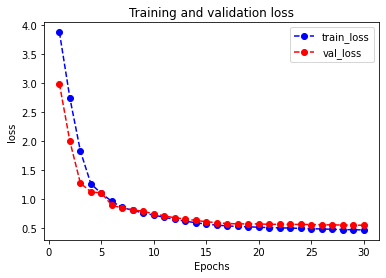

In [37]:
plot_metric(history,"loss")

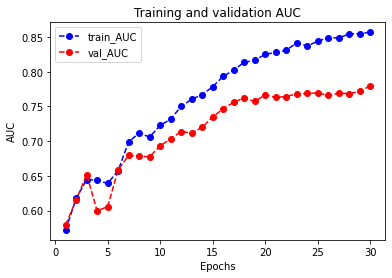

In [38]:
plot_metric(history,"AUC")

#### 我们再看下模型在测试集上的效果

In [39]:
model.evaluate(x=x_test,y=y_test)

179/179 [==============================] - 0s 66us/sample - loss: 0.4935 - AUC: 0.8406


[0.49347947446327634, 0.8405857]

# 五、使用模型

In [40]:
model.predict(x_test[0:10])

array([[0.31593814],
       [0.50485206],
       [0.41273287],
       [0.7832473 ],
       [0.47768936],
       [0.55183744],
       [0.12631845],
       [0.6395751 ],
       [0.28999737],
       [0.2279673 ]], dtype=float32)

In [41]:
model.predict_classes(x_test[0:10])

array([[0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0]], dtype=int32)

# 六、保存模型
可以使用Keras方式保存模型，也可以使用Tensorflow原生方式保存。前者仅仅适用使用Python环境恢复模型，后者则可以跨平台进行模型部署。
推荐使用后一种方式进行保存

In [42]:
#1.Keras方式保存
model.save("./data/keras_model.h5")
del model

model = models.load_model("./data/keras_model.h5")
model.evaluate(x_test,y_test)

179/179 [==============================] - 0s 1ms/sample - loss: 0.4935 - AUC: 0.8406


[0.49347947446327634, 0.8405857]

In [44]:
#保存模型结构
json_str = model.to_json()
#恢复模型结构
model_json = models.model_from_json(json_str)

In [47]:
#保存模型权重
model.save_weights("./data/keras_model_weight.h5")
#恢复模型结构
model_json = models.model_from_json(json_str)
model_json.compile(optimizer='adam',loss='binary_crossentropy',metrics=['AUC'])
model_json.load_weights('./data/keras_model_weight.h5')
model_json.evaluate(x_test,y_test)

179/179 [==============================] - 0s 1ms/sample - loss: 0.4935 - AUC: 0.8406


[0.49347947446327634, 0.8405857]

### 2、Tensorflow原生方式保存

In [49]:
model.save_weights('./data/tf_model_weights.ckpt',save_format="tf")

In [51]:
model.save("./data/tf_model_savedmodel",save_format="tf")
print("export saved model")

model_loaded = tf.keras.models.load_model("./data/tf_model_savedmodel/")
model_loaded.evaluate(x_test,y_test)

INFO:tensorflow:Assets written to: ./data/tf_model_savedmodel/assets
export saved model
179/179 [==============================] - 0s 1ms/sample - loss: 0.4935 - AUC: 0.8406


[0.4934792701758486, 0.8405857]